# Collaborative Filtering Recommender System

## Import Libraries

In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [273]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=columns)
df.shape

(100000, 4)

In [274]:
r_cols = ['user_id', 'item_id', 'rating', 'timestamp']
train = pd.read_csv('ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')
test = pd.read_csv('ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')
train.shape, test.shape

((90570, 4), (9430, 4))

In [275]:
df.head(n=2)

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742


In [276]:
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.head(n=2)

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)


In [277]:
# Merge 2 dataet together
df = pd.merge(df,movie_titles,on='item_id')
train = pd.merge(train,movie_titles,on='item_id')
test = pd.merge(test,movie_titles,on='item_id')
train.head()

,user_id,item_id,rating,timestamp,title
0,1,1,5,874965758,Toy Story (1995)
1,2,1,4,888550871,Toy Story (1995)
2,6,1,4,883599478,Toy Story (1995)
3,10,1,4,877888877,Toy Story (1995)
4,13,1,3,882140487,Toy Story (1995)


# Exploratory Data Analysis (EDA)

In [278]:
df.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [280]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [281]:
ratings['number_ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,number_ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


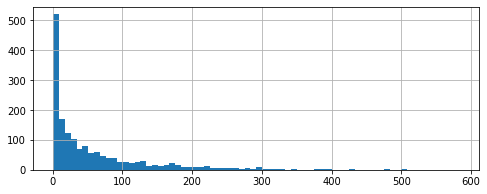

In [282]:
#We can see from the below figure that most of the movies have few number of ratings.
plt.figure(figsize=(8,3))
ratings['number_ratings'].hist(bins=70)

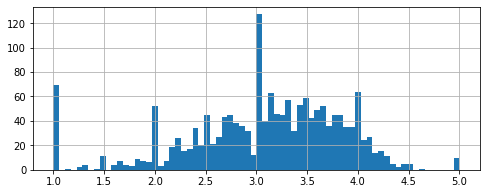

In [283]:
# This histogram shows the distribution of rating 
plt.figure(figsize=(8,3))
ratings['rating'].hist(bins=70)

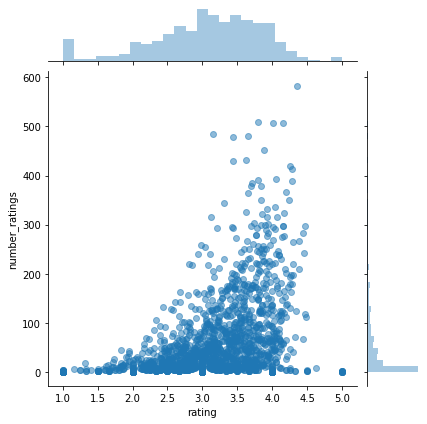

In [284]:
# More rating highest number of rating
sns.jointplot(x='rating',y='number_ratings',data=ratings,alpha=0.5)
plt.show()

# Find Similar Movies

In [285]:
movie_matrix = df.pivot_table(index='user_id',columns='title',values='rating')

In [286]:
movie_matrix.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN


In [287]:
def find_similar_movies(movie_name):
    #Select user ratings for two movies 
    movie_user_ratings = movie_matrix[movie_name]

    # Find correlations between series with corrwith (instead of corr)
    similar_to_movie = movie_matrix.corrwith(movie_user_ratings)

    # Removing NaN values and using a DataFrame instead of a series 
    corr_movies = pd.DataFrame(similar_to_movie,columns=['Correlation'])
    corr_movies.dropna(inplace=True)

    corr_movies = corr_movies.join(ratings['number_ratings'])

    result = corr_movies[corr_movies['number_ratings']>100].sort_values('Correlation',ascending=False).head()
    return result

In [288]:
find_similar_movies('Die Hard (1988)')

,Correlation,number_ratings
title,,
Die Hard (1988),1.000000,243
Die Hard: With a Vengeance (1995),0.577216,151
Die Hard 2 (1990),0.510473,166
Absolute Power (1997),0.477706,127
Nikita (La Femme Nikita) (1990),0.444070,127


# Recommendation Engine - collaborative filtering model from scratch

In [291]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
n_users,n_items

(943, 1682)

In [329]:
# create a user-item matrix which can be used to calculate the similarity between users and items

data_matrix = np.zeros((n_users, n_items))
for line in df.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]
    
train_data_matrix = np.zeros((n_users, n_items))
# unpack the Pandas object
for line in train.itertuples():
    # adjust to count rows and cols from 0 and fill in the matrix
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in test.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [331]:
# calculating the similarity by using the pairwise_distance from sklearn to calculate the cosine similarity
from sklearn.metrics.pairwise import pairwise_distances 

# user-user similarity
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')

# item-item similarity
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

user_similarity.shape , item_similarity.shape

((943, 943), (1682, 1682))

we can make a prediction by applying the following formula for user-based CF.

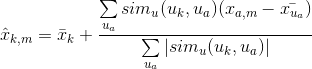

1) We can look at the similarity between users k and a as weights that are

2)  multiplied by the ratings of a similar user a (corrected for the average rating of that user)

3) We need to normalize it so that the ratings stay between 1 and 5

4) As a final step, sum the average ratings for the user that you are trying to predict.

Also, we can make a prediction by applying the following formula for item-based CF.

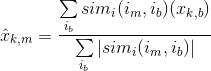

In [332]:
#make predictions based on these similarities

def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [333]:
user_prediction = predict(data_matrix, user_similarity, type='user')
item_prediction = predict(data_matrix, item_similarity, type='item')

In [335]:
user_prediction.nonzero()

(array([  0,   0,   0,   0, ..., 942, 942, 942, 942]),
 array([   0,    1,    2,    3, ..., 1678, 1679, 1680, 1681]))

## Evaluation

In [337]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.105678174637224
Item-based CF RMSE: 3.588904192097963


## Model-based collaborative filtering

In [339]:
sparsity = round(1.0-len(df)/float(n_users*n_items), 3)
print('The sparsity level of MovieLens100K is ' + str(sparsity*100) + '%')


import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k=20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

The sparsity level of MovieLens100K is 93.7%
User-based CF MSE: 2.8258075694458307


# Fast AI

In [340]:
df.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [341]:
# import collaborative filtering package
from fastai.collab import *

In [308]:
# Turn the title columns in category codes(to replace them with their codes for an Embedding layer)
# size of our validation set = 0.1
# we can add rating_name and user_name too.

data = CollabDataBunch.from_df(df, seed=42, valid_pct=0.1, item_name='title')

In [309]:
#show a random batch of our data
data.show_batch()

user_id,title,target
375,"Big Sleep, The (1946)",4.0
642,"Fish Called Wanda, A (1988)",3.0
218,Pulp Fiction (1994),3.0
642,Mr. Holland's Opus (1995),5.0
452,Sunset Blvd. (1950),4.0


In [310]:
#getting the max and min values of our ratings
df.rating.min(), df.rating.max()

(1, 5)

## EmbeddingDotBias

In [311]:
# creat Learner object (our model)
# n_factors represents the size of the embedding vectors

#EmbeddingDotBias
learn = collab_learner(data, n_factors=40, y_range=(1,5), wd=1e-1)


#EmbeddingNN Model
#learn = collab_learner(data, n_factors=40, y_range=(1,5), use_nn=True, layers=[256, 128])

In [316]:
print(learn.model)

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


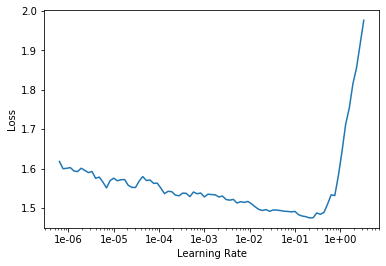

In [312]:
# find the perfect learning rates we can use the lr_find 
learn.lr_find()
# plot learning rate graph
learn.recorder.plot()

In [313]:
# Train our model using the fit_one_cycle method
learn.fit_one_cycle(4, 1e-02)

epoch,train_loss,valid_loss,time
0,0.952097,0.947214,00:13
1,0.858333,0.878648,00:12
2,0.752914,0.827183,00:11
3,0.588684,0.822923,00:11


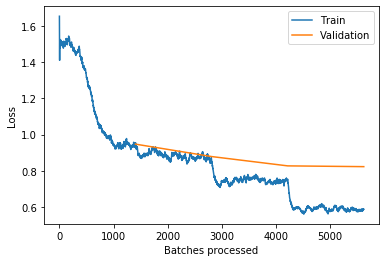

In [314]:
learn.recorder.plot_losses()

In [315]:
learn.save('movie-dot-1')

In [120]:
df.iloc[250]

user_id                   426
item_id                    50
rating                      4
timestamp           879442226
title        Star Wars (1977)
Name: 250, dtype: object

In [121]:
learn.predict(df.iloc[250])

(FloatItem [4.414546], tensor([4.4145]), tensor([4.4145]))

In [122]:
learn.get_preds(ds_type=DatasetType.Valid)

[tensor([[3.4350],
         [3.6854],
         [4.1307],
         ...,
         [2.6932],
         [4.0828],
         [4.1881]]), tensor([4., 4., 4.,  ..., 3., 5., 4.])]

In [123]:
Mapping_file= dict(zip(df.title.tolist(),df.item_id.tolist()))

In [124]:
def pred_user_rating(ui):
    if ui in df.user_id.unique():
        ui_list = df[df.user_id == ui].item_id.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}
        
        predictedL = []
        for i, j in d.items():     
            predicted = learn.predict(df.iloc[ui])
            predictedL.append((i, predicted[0])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

In [125]:
df.iloc[8]

user_id                   305
item_id                    50
rating                      5
timestamp           886321799
title        Star Wars (1977)
Name: 8, dtype: object

In [126]:
predicted = learn.predict(df.iloc[8])
predicted[0]

FloatItem [4.274739]

In [127]:
user_id = 9
pred = pred_user_rating(user_id)
pred

,ratings
movies,
"Empire Strikes Back, The (1980)",[4.564302]
Gone with the Wind (1939),[4.564302]
L.A. Confidential (1997),[4.564302]
Heavyweights (1994),[4.564302]
Legends of the Fall (1994),[4.564302]
Jackie Brown (1997),[4.564302]
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963),[4.564302]
"Hunt for Red October, The (1990)",[4.564302]
"Jungle Book, The (1994)",[4.564302]


In [129]:
user_9 = df[df['user_id']==9]
user_9

,user_id,item_id,rating,timestamp,title
412,9,50,5,886960055,Star Wars (1977)
1175,9,242,4,886958715,Kolya (1996)
7793,9,201,5,886960055,Evil Dead II (1987)
12704,9,690,1,886959344,Seven Years in Tibet (1997)
16361,9,294,4,886959453,Liar Liar (1997)
20402,9,385,5,886960055,True Lies (1994)
21691,9,479,4,886959343,Vertigo (1958)
25429,9,298,5,886960055,Face/Off (1997)
28180,9,483,5,886960056,Casablanca (1942)
33437,9,7,4,886960030,Twelve Monkeys (1995)


In [131]:
t = 0
for i in range(len(user_9)):
    if user_9['title'].iloc[i] in pred.index:
        t+=1
print(t)
        

0


# Keras Implementation

In [134]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [136]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [138]:
# number of unique users
n_users = len(train.user_id.unique())
n_users

944

In [140]:
#number of unique movies
n_movies = len(train.item_id.unique())
n_movies

1649

In [141]:
# Create Movie Embedding
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(200000, 5, name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='Movie-Vector')(movie_embedding)

In [142]:
# Create User Embedding
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(200000, 5, name='User-Embedding')(user_input)
user_vec = Flatten(name='User-Vector')(user_embedding)

In [143]:
# Concatenate two vectors
conc = Concatenate()([user_vec, movie_vec])

In [145]:
# fully connected layers

from tensorflow.keras.models import Sequential
model = Sequential()

fc1 = Dense(128, activation='relu')(conc)
fc1 = Dropout(0.3)(fc1)
fc2 = Dense(32, activation='relu')(fc1)
fc2 = Dropout(0.3)(fc2)
out = Dense(1)(fc2)

# Create Model and Compile it

model = Model([user_input, movie_input], out)
model.compile('adam', 'mean_squared_error')

Train on 80002 samples
Epoch 1/15
80002/80002 [==============================] - 61s 762us/sample - loss: 1.4070
Epoch 2/15
80002/80002 [==============================] - 57s 712us/sample - loss: 1.0622
Epoch 3/15
80002/80002 [==============================] - 61s 760us/sample - loss: 0.9702
Epoch 4/15
80002/80002 [==============================] - 64s 806us/sample - loss: 0.9179
Epoch 5/15
80002/80002 [==============================] - 64s 797us/sample - loss: 0.8756
Epoch 6/15
80002/80002 [==============================] - 60s 747us/sample - loss: 0.8479
Epoch 7/15
80002/80002 [==============================] - 62s 769us/sample - loss: 0.8284
Epoch 8/15
80002/80002 [==============================] - 54s 678us/sample - loss: 0.8089
Epoch 9/15
80002/80002 [==============================] - 64s 800us/sample - loss: 0.7957
Epoch 10/15
80002/80002 [==============================] - 58s 728us/sample - loss: 0.7822
Epoch 11/15
80002/80002 [==============================] - 64s 795us/sample 

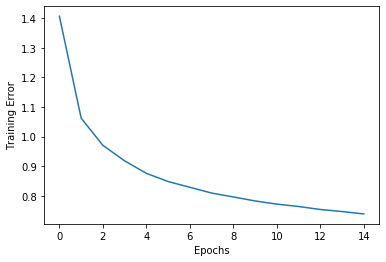

In [147]:
## time consuming
from tensorflow.keras.models import load_model

if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.user_id, train.item_id], train.rating, epochs=15, verbose=1)
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [148]:
model.evaluate([test.user_id, test.item_id], test.rating)

20001/20001 [==============================] - 1s 35us/sample - loss: 0.8666


0.8665732793944121

In [149]:
predictions = model.predict([test.user_id.head(10), test.item_id.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[3.166937] 4
[3.731212] 4
[3.702734] 4
[3.7792] 5
[4.748646] 5
[4.309113] 3
[4.896811] 5
[1.911487] 3
[3.99135] 3
[3.535674] 3


[None, None, None, None, None, None, None, None, None, None]

# Prediction

In [150]:
movie_data = np.array(list(set(df.item_id)))
movie_data[:5]

array([1, 2, 3, 4, 5])

In [151]:
user_data = np.array([1 for i in range(len(movie_data))])
user_data[:5]

array([1, 1, 1, 1, 1])

In [152]:
predictions = model.predict([user_data, movie_data])
predictions = np.array([a[0] for a in predictions])
predictions[:5]

array([4.020773, 2.751744, 2.980328, 4.004249, 2.908504], dtype=float32)

In [153]:
recommended_movie_ids = (-predictions).argsort()[:5]

recommended_movie_ids

array([1366, 1397, 1448, 1535, 1466])

In [154]:
predictions[recommended_movie_ids]

array([5.203668, 5.180012, 5.178625, 5.173798, 5.139695], dtype=float32)

In [155]:
df[df.item_id == 5877]

,user_id,item_id,rating,timestamp,title


In [156]:
df[df['item_id'].isin(recommended_movie_ids)]

,user_id,item_id,rating,timestamp,title
77099,234,1397,4,892334976,Of Human Bondage (1934)
77100,184,1397,3,889910233,Of Human Bondage (1934)
77101,269,1397,4,891450575,Of Human Bondage (1934)
77102,707,1397,1,886289521,Of Human Bondage (1934)
77103,932,1397,4,891250793,Of Human Bondage (1934)
97265,243,1466,3,879988104,Margaret's Museum (1995)
97266,280,1466,5,891700836,Margaret's Museum (1995)
97267,711,1466,4,883589693,Margaret's Museum (1995)
97268,655,1466,3,890497592,Margaret's Museum (1995)
97269,354,1466,5,891217547,Margaret's Museum (1995)


# Sources
https://course.fast.ai/videos/?lesson=4

https://towardsdatascience.com/collaborative-filtering-with-fastai-3dbdd4ef4f00

https://github.com/TannerGilbert/Tutorials/blob/master/FastAI/Book%20Recommendation%20System.ipynb

https://medium.com/quantyca/deep-learning-for-collaborative-filtering-using-fastai-b28e197ccd59

https://www.kaggle.com/abhikjha/movielens-fastai-collab
